This notebook analyzes disaster tweets using `MultiNomialNB` classifier. The task was carried in a colab notebook. The task is from [this kaggle competition](https://www.kaggle.com/c/nlp-getting-started/leaderboard). This notebook replicates some steps from [Diksha Bhati](https://www.kaggle.com/dikshabhati2002) (a lot of credits to her), a kaggle user, whose [submission](https://www.kaggle.com/dikshabhati2002/nlp-for-beginners) on this competition titled **NLP for beginners** detailed basic intorduction to NLP. 
This notebook utilizes three classifier algorithms (XGBoost, Logistics regression and Multinomial Naive Bayes, classifiers) and two texts transformers (CountVectorizer and TFIDF Vectorizer), finds the ones with the highest predictive power and predicted the test set using these. 

The tasks is broken down into four:  
1. Exploratory Data Analysis
2. Data Cleaning
3. Modelling and
4. Prediction

In [ ]:
# import numpy and pandas modules
import numpy as np
import pandas as pd

In [ ]:
# import the google drive module
from google.colab import drive

In [ ]:
# use the drive module to mount a google drive folder
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# the following code provides the configuration path to the kaggle.json file in my drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/Kaggle'

In [ ]:
# change the current working directory to the kaggle folder in My Drive
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
# Download the kaggle dataset
# Go to kaggle and copy the API Command to download the dataset
!kaggle competitions download -c nlp-getting-started

401 - Unauthorized


In [ ]:
# check the contents of thee current working directory to verify the downloads
!ls

Analyze_Disaster_Tweets_Using_NLP.ipynb  my_submission_data.csv  train.csv
insurance.csv				 sample_submission.csv
kaggle.json				 test.csv


In [ ]:
# load the dataset
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
submission_data = pd.read_csv('./sample_submission.csv')

# check train data head
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# check test data head
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# check submissions_sample data head
submission_data.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


## Exploratory Data Analysis

In [ ]:
# get dimensions of training set
print(f"The number of rows in the training set are: {train_data.shape[0]} \nThe total number of columns for the training set are: {train_data.shape[1]}")

# get dimensions of test set
print(f"\n\nThe number of rows in the test set are: {test_data.shape[0]} \nThe total number of columns for the test set are: {test_data.shape[1]}")

The number of rows in the training set are: 7613 
The total number of columns for the training set are: 5


The number of rows in the test set are: 3263 
The total number of columns for the test set are: 4


In [ ]:
# basic info of training dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
# some basic info of the test dataset
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [ ]:
# get the sum of null values in all columns of the training dataset
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
# get the sum of null values in all columns of the test dataset
test_data.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

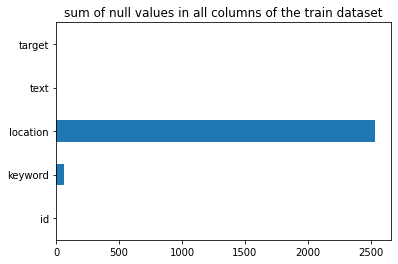

In [ ]:
# import the matplotlib.pyplot module
import matplotlib.pyplot as plt

# plot the sum of null values in all columns of the train dataset
train_data.isnull().sum().plot(kind = 'barh')
plt.title('sum of null values in all columns of the train dataset')
plt.show()

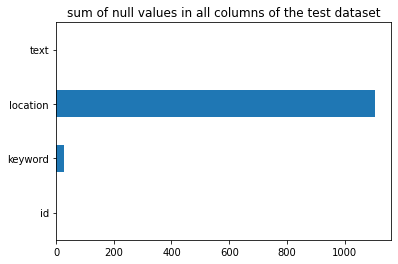

In [ ]:
# plot the sum of null values in all columns of the test dataset
test_data.isnull().sum().plot(kind = 'barh')
plt.title('sum of null values in all columns of the test dataset')
plt.show()

`Location` and `keyword` columns have the highest number of null values in both the train and test datasets. Since we do not need these two columns in order to classify a tweet as disasterous or not... we'll be dropping them for the two datasets

In [ ]:
# drop location and keyword columns for the train dataset
train_data = train_data.drop(['location', 'keyword'], axis=1)

# check the train dataset after dropping the location and keyword columns
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# drop location and keyword columns for the test dataset
test_data = test_data.drop(['location', 'keyword'], axis=1)

# check the test dataset after dropping the location and keyword columns
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


The classification of the `target` details whether a particular tweet is about a real disaster or not. Real disaster tweet are represented by `1` while non-disaster tweets are represented by `0`

Below, we'll find the percentage of real disaster tweets and non-disaster tweets

In [ ]:
# get the number of real tweets
num_real_tweets = len(train_data[train_data['target'] == 1])

# get the percentage of real tweets
percent_real_tweets = (num_real_tweets/len(train_data)) * 100

# get the percentage of fake tweets
percent_fake_tweets = 100 - percent_real_tweets

print(f"The percentage of real disaster tweets in the dataset is: {round(percent_real_tweets, 2)}\n")
print(f"While the percentage of fake disaster tweets in the dataset is: {round(percent_fake_tweets, 2)}")

The percentage of real disaster tweets in the dataset is: 42.97

While the percentage of fake disaster tweets in the dataset is: 57.03


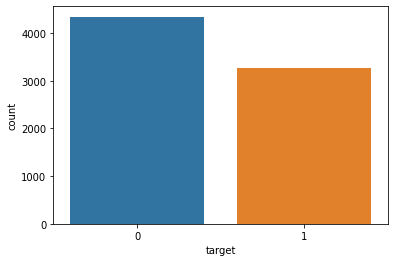

In [ ]:
# import the seaborn module
import seaborn as sns 

# plot the counts of the target values
sns.countplot(x = 'target', data=train_data)
plt.show()

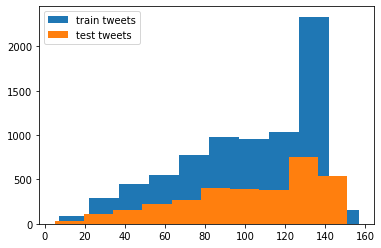

In [ ]:
# get the length of all the tweets in the train data
length_train_tweets = train_data['text'].str.len()
length_test_tweets = test_data['text'].str.len()

# plot the histogram distribution of the number of tweets in the both the train and test dataset
plt.hist(length_train_tweets, label='train tweets')
plt.hist(length_test_tweets, label='test tweets')
plt.legend()
plt.show()

Majority of the tweets in the train dataset have less than one thousand texts, while most tweets in the test dataset have less than 500 texts.

In [ ]:
# get the disaster tweets only
disaster_tweets = train_data[train_data['target'] == 1]['text']

# show the first 10 disaster tweets
for i in range(10):
  print(disaster_tweets[i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...


In [ ]:
non_disaster_tweets = train_data[train_data['target'] != 1]['text']

# show the first 10 non-disaster tweets
for i in range(15, 25):
  print(non_disaster_tweets[i])


What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!
this is ridiculous....
London is cool ;)
Love skiing
What a wonderful day!
LOOOOOOL


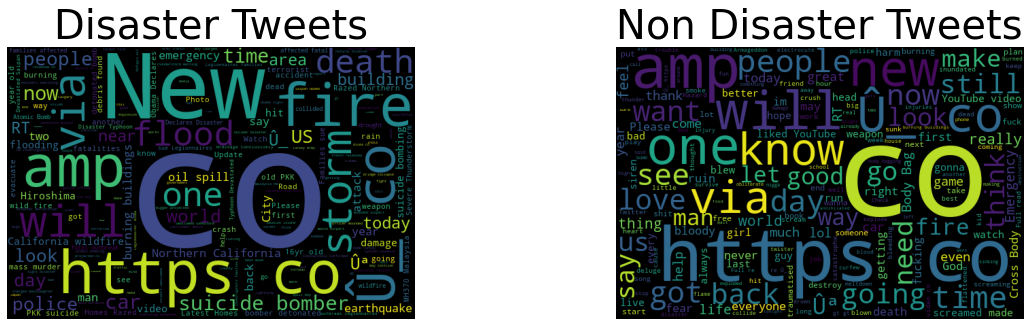

In [ ]:
# display wordcloud of disaster and non disaster tweets
# import the word cloud module
from wordcloud import  WordCloud

# generate and unpack the subplots to hold wordcloud diagrams
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [20, 5])

# instantiate a first wordcloud and tune its parameters as desired
wordcloud1 = WordCloud(background_color='black', width=600, height=400)

# parse the disaster tweets to the instance of the wordcloud
disaster_wordcloud = wordcloud1.generate(" ".join(disaster_tweets))

# show the wordcloud1 on the first axis
ax1.imshow(wordcloud1)
# remove the axis spines
ax1.axis('off')
# set the title of the first axis holding disaster tweets
ax1.set_title('Disaster Tweets', fontsize = 40)


# instantiate a second wordcloud and tune its parameters as desired
wordcloud2 = WordCloud(background_color='black', width=600, height=400)

# parse the non_disaster tweets to the second instance of the wordcloud
non_disaster_wordcloud = wordcloud2.generate(''.join(non_disaster_tweets))

# show the wordcloud2 on the second axis
ax2.imshow(wordcloud2)
# remove the axis spines
ax2.axis('off')
# set the title of the first axis holding disaster tweets
ax2.set_title('Non Disaster Tweets', fontsize = 40)
plt.show()

# Data Cleaning

In [ ]:
# cleaning the text
# import the regular expressions module
import re
import string

def clean_text(text):
  """
  and remove words containing numbers.
  """
  # make all texts lower case
  text = text.lower()
  # remove texts in square brackets
  text = re.sub('\[.*?\]', '', text)
  # remove links from texts
  text = re.sub('https?://\S+|www\.\S+', '', text)
  # remove punctuations
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  # remove new line characters
  text = re.sub('\n', '', text)
  # remove digits
  text = re.sub('\w*\d\w*', '', text)

  return text

# Apply the clean text function to the tweets in train and test datasets
train_data['text'] = train_data['text'].apply(lambda x: clean_text(x))
test_data['text'] = test_data['text'].apply(lambda x: clean_text(x))

# check the cleaned train data texts
train_data['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [ ]:
# NLTK is a leading platform for building Python programs to work with human language data.
# NLTK Tokenizers package divide strings into lists of substrings. For example, tokenizers can be used to find the words and punctuation in a string.
# The RegexpTokenizer splits a string into substrings using a regular expression.
import nltk

# instantiate a regex tokenizer to split word characters that occur once or more
regex_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# apply the regex tokenizer on the tweets of train and test datasets
train_data['text'] = train_data['text'].apply(lambda x: regex_tokenizer.tokenize(x))
test_data['text'] = test_data['text'].apply(lambda x: regex_tokenizer.tokenize(x))

# check
train_data.head(10)

,id,text,target
0,1,"[our, deeds, are, the, reason, of, this, earth...",1
1,4,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,"[all, residents, asked, to, shelter, in, place...",1
3,6,"[people, receive, wildfires, evacuation, order...",1
4,7,"[just, got, sent, this, photo, from, ruby, ala...",1
5,8,"[rockyfire, update, california, hwy, closed, i...",1
6,10,"[flood, disaster, heavy, rain, causes, flash, ...",1
7,13,"[im, on, top, of, the, hill, and, i, can, see,...",1
8,14,"[theres, an, emergency, evacuation, happening,...",1
9,15,"[im, afraid, that, the, tornado, is, coming, t...",1


# Stop Words
Stopwords are those english words which do not add much meaning to a sentence.They are very commonly used words and we do not required those words. So we can remove those stopwords from the train and test datasets.

In [ ]:
# download stopwords from the nltk package
nltk.download('stopwords')
# A corpus is a collection of written texts, especially the entire works of a particular author or a body of writing on a particular subject.
# Each corpus module defines one or more “corpus reader functions”, which can be used to read documents from that corpus.
# These functions take an argument, item, which is used to indicate which document should be read from the corpus:
from nltk.corpus import stopwords

# get the words function from the stopwords module and read the english stopwords document
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
# get the length of english stopwords
len(stopwords.words('english'))

179

In [ ]:
# remove stopwords from the train and test datasets
def remove_stopwords(text):
  words = []
  for w in text:
    if w not in stopwords.words('english'):
      words.append(w)

  return words

# apply the function to the tweets of the train and test dataset
train_data['text'] = train_data['text'].apply(lambda x: remove_stopwords(x))
test_data['text'] = test_data['text'].apply(lambda x: remove_stopwords(x))

# check
train_data.head(10)

,id,text,target
0,1,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,"[residents, asked, shelter, place, notified, o...",1
3,6,"[people, receive, wildfires, evacuation, order...",1
4,7,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1
5,8,"[rockyfire, update, california, hwy, closed, d...",1
6,10,"[flood, disaster, heavy, rain, causes, flash, ...",1
7,13,"[im, top, hill, see, fire, woods]",1
8,14,"[theres, emergency, evacuation, happening, bui...",1
9,15,"[im, afraid, tornado, coming, area]",1


In [ ]:
# check for the test dataset
test_data.head(10)

,id,text
0,0,"[happened, terrible, car, crash]"
1,2,"[heard, earthquake, different, cities, stay, s..."
2,3,"[forest, fire, spot, pond, geese, fleeing, acr..."
3,9,"[apocalypse, lighting, spokane, wildfires]"
4,11,"[typhoon, soudelor, kills, china, taiwan]"
5,12,"[shakingits, earthquake]"
6,21,"[theyd, probably, still, show, life, arsenal, ..."
7,22,[hey]
8,27,"[nice, hat]"
9,29,[fuck]


# Lemmatization
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item.

Examples of lemmatization:

1.`playing` ,`plays` and `played` all these 3 letters will be converted to `play` after lemmatization

2.`change` , `changing` , `changes` , `changed` and `changer` all these letters will be converted to `change` after lemmatization

The nltk.stem module is a processing interface for removing morphological affixes (an addition to the base form or stem of a word in order to modify its meaning or create a new word) from words. This process is known as stemming.

Lemmatize using WordNet’s built-in morphy function. Returns the input word unchanged if it cannot be found in WordNet.

The stem of a word is the base word while the affixes are additions to the stem that could change its meaning. E.g Fast is the stem of Fastly or Fasting.

In [ ]:
# download the wordnet class
nltk.download('wordnet')
# import Lemmatizer
from nltk.stem import WordNetLemmatizer

# instantiate the wordnetlemmatizer
lemmatizer = WordNetLemmatizer()

# create a function to lemmatize words
def lem_word(texts):
  words = []
  for word in texts:
    words.append(lemmatizer.lemmatize(word))

  return words

# apply the lemmatizer function to the tweets in train and test data
train_data['text'] = train_data['text'].apply(lem_word)
test_data['text'] = test_data['text'].apply(lem_word)

# check the lemmatized train data
train_data.head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,text,target
0,1,"[deed, reason, earthquake, may, allah, forgive...",1
1,4,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,"[resident, asked, shelter, place, notified, of...",1
3,6,"[people, receive, wildfire, evacuation, order,...",1
4,7,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1
5,8,"[rockyfire, update, california, hwy, closed, d...",1
6,10,"[flood, disaster, heavy, rain, cause, flash, f...",1
7,13,"[im, top, hill, see, fire, wood]",1
8,14,"[there, emergency, evacuation, happening, buil...",1
9,15,"[im, afraid, tornado, coming, area]",1


In [ ]:
# convert the tweets in the train and test datasets from lists to strings
test_data['text'] = test_data['text'].apply(lambda x: ' '.join(x))
train_data['text'] = train_data['text'].apply(lambda x: ' '.join(x))

# check the test data
test_data.head(10)

,id,text
0,0,happened terrible car crash
1,2,heard earthquake different city stay safe ever...
2,3,forest fire spot pond goose fleeing across str...
3,9,apocalypse lighting spokane wildfire
4,11,typhoon soudelor kill china taiwan
5,12,shakingits earthquake
6,21,theyd probably still show life arsenal yesterd...
7,22,hey
8,27,nice hat
9,29,fuck


In [ ]:
# check the train data
train_data.head(10)

,id,text,target
0,1,deed reason earthquake may allah forgive u,1
1,4,forest fire near la ronge sask canada,1
2,5,resident asked shelter place notified officer ...,1
3,6,people receive wildfire evacuation order calif...,1
4,7,got sent photo ruby alaska smoke wildfire pour...,1
5,8,rockyfire update california hwy closed directi...,1
6,10,flood disaster heavy rain cause flash flooding...,1
7,13,im top hill see fire wood,1
8,14,there emergency evacuation happening building ...,1
9,15,im afraid tornado coming area,1


# Count-Vector

In order to use textual data for predictive modeling, the text must be parsed to remove certain words – this process is called tokenization. These words need to then be encoded as integers, or floating-point values, for use as inputs in machine learning algorithms. This process is called feature extraction (or vectorization).

#### Using count vectorizer

CountVectorizer is used to transform a given text into a vector on the basis of the frequency(count) of each word that occurs in the entire text. It involves counting the number of occurences each words appears in a document(text). check [this](https://kavita-ganesan.com/how-to-use-countvectorizer/#.YAroOuhKj4a) for usage of count vectorizer

#### Using TF-IDF
It stands for `Term Frequency-Inverse document frequency`.It is a techinque to quantify a word in documents,we generally compute a weight to each word which signifies the importance of the word in the document and corpus

In [ ]:
# first we'll use count vectorizer to convert text data
# import countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the count vectorizer
count_vectorizer = CountVectorizer()

# convert the tweets of the training dataset to a vector using countvectorizer
train_tweets_vector_count = count_vectorizer.fit_transform(train_data['text'])

# apply the transformation on the test set
test_tweets_vector_count = count_vectorizer.transform(test_data['text'])

# convert the vector to a numpy array and also check the shape of the array
print(f"The shape of the training count vectorizer is: ", train_tweets_vector_count.toarray().shape)
print(f'The training vector for count vectorizer looks like this: \n', train_tweets_vector_count.toarray(), '\n')

print(f"The shape of the test count vectorizer is: ", test_tweets_vector_count.toarray().shape)
print(f'The test vector for count vectorizer looks like this: \n', test_tweets_vector_count.toarray())

The shape of the training count vectorizer is:  (7613, 15128)
The training vector for count vectorizer looks like this: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

The shape of the test count vectorizer is:  (3263, 15128)
The test vector for count vectorizer looks like this: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Next we'll use tfidf vectorizer to convert text data
# import tfidfvectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# instantiate the count vectorizer
tfidf_vectorizer = TfidfVectorizer()

# convert the tweets of the training dataset to a vector using countvectorizer
train_tweets_vector_tfidf = tfidf_vectorizer.fit_transform(train_data['text'])

# apply the transformation on the test set
test_tweets_vector_tfidf = tfidf_vectorizer.transform(test_data['text'])

# convert the vector to a numpy array and also check the shape of the array
print(f"The shape of the training tfidf vectorizer is: ", train_tweets_vector_tfidf.toarray().shape)
print(f'The training vector for the tfidf vectorizer looks like this: \n', train_tweets_vector_tfidf.toarray(), '\n')

print(f"The shape of the test tfidf vectorizer is: ", test_tweets_vector_tfidf.toarray().shape)
print(f'The test vector for the tfidf vectorizer looks like this: \n', test_tweets_vector_tfidf.toarray())

The shape of the training tfidf vectorizer is:  (7613, 15128)
The training vector for the tfidf vectorizer looks like this: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

The shape of the test tfidf vectorizer is:  (3263, 15128)
The test vector for the tfidf vectorizer looks like this: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Using XGB Classifier
- This [link](https://xgboost.readthedocs.io/en/latest//tutorials/param_tuning.html) shows how to control the parameters for several purposes using xgboost 
- This [link](https://xgboost.readthedocs.io/en/latest//parameter.html) also helps tune the parameters as appropriate and this [link](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

We'll use the count vectorizer vector with the xgboost algorithm first, then we'll use the tfidf vectorizer vector next. We'll use these together with cross validation to improve model performance. 

In [ ]:
%%time
# import the xgb algorithm
import xgboost as xgb

# import the cross validation scores from sklearn.model_selection module
from sklearn.model_selection import cross_val_score

# instantiate the xgboost classifier and set some parameters
xgb_params = xgb.XGBClassifier()

# instantiate the cross val score and pass the parameters, features and target and count vectorizer model
score_of_count_vectors = cross_val_score(xgb_params, train_tweets_vector_count, train_data['target'], cv = 5,  scoring = 'f1')

# check
print('XGB Average f1 Score using count vectorizer and 5 fold CV: ', np.mean(score_of_count_vectors))

# instantiate the cross val score and pass the parameters, features and target and tfidf vectorizer model
score_of_tfidf_vectors = cross_val_score(xgb_params, train_tweets_vector_tfidf, train_data['target'], cv = 5,  scoring = 'f1')

# check
print('XGB Average f1 Score using tfidf vectorizer and 5 fold CV: ', np.mean(score_of_tfidf_vectors))


XGB Average f1 Score using count vectorizer and 5 fold CV:  0.37368344088336675
XGB Average f1 Score using tfidf vectorizer and 5 fold CV:  0.37606856710263126
CPU times: user 22.9 s, sys: 80.9 ms, total: 23 s
Wall time: 23.1 s


In [ ]:
# show the parameters used for the xgboost classifier algorithm
xgb_params.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

# Using MultiNomial Naive Bayes [link](https://towardsdatascience.com/why-how-to-use-the-naive-bayes-algorithms-in-a-regulated-industry-with-sklearn-python-code-dbd8304ab2cf)

In [ ]:
%%time

# import multinomial naive bayes classifier
from sklearn.naive_bayes import MultinomialNB

# instantiantiate the multinomial naive bayes with an alpha parameter of 2
mnb = MultinomialNB(alpha = 2.0)

# perform a 5 fold cross validation on the training count vectorizer using the MultinomialNB algorithm
mnb_scores_count_vector = cross_val_score(mnb, train_tweets_vector_count, train_data['target'], cv = 5, scoring= 'f1')

# print the scores
print('Multinomial Naive Bayes Average f1 Score using count vectorizer and 5 fold CV: ', np.mean(mnb_scores_count_vector), '\n')

# perform a 10 fold cross validation on the training tf-idf vectorizer using the MultinomialNB algorithm
mnb_scores_tfidf_vector = cross_val_score(mnb, train_tweets_vector_tfidf, train_data['target'], cv = 5, scoring= 'f1')

# print the scores
print('Multinomial Naive Bayes Average f1 Score using tfidf vectorizer and 5 fold CV: ', np.mean(mnb_scores_tfidf_vector))

Multinomial Naive Bayes Average f1 Score using count vectorizer and 5 fold CV:  0.6627362910518635 

Multinomial Naive Bayes Average f1 Score using tfidf vectorizer and 5 fold CV:  0.6244012689257147
CPU times: user 72.1 ms, sys: 3.02 ms, total: 75.1 ms
Wall time: 74.6 ms


In [ ]:
# get the multinomial naive bayes parameters
mnb.get_params()

{'alpha': 2.0, 'class_prior': None, 'fit_prior': True}

# Using Logistics Regression


In [ ]:
%%time

# import Logistics regression classifier
from sklearn.linear_model import LogisticRegression

# instantiantiate the logistics regression classifier with default parameters
logreg = LogisticRegression()

# perform a 5 fold cross validation on the training count vectorizer using the Logistic regression algorithm
logreg_scores_count_vector = cross_val_score(logreg, train_tweets_vector_count, train_data['target'], cv = 5, scoring= 'f1')

# print the scores
print('Logistics regression Average f1 Score using count vectorizer and 5 fold CV: ', np.mean(logreg_scores_count_vector), '\n')

# perform a 5 fold cross validation on the training tf-idf vectorizer using the Logistic regression algorithm
logreg_scores_tfidf_vector = cross_val_score(logreg, train_tweets_vector_tfidf, train_data['target'], cv = 5, scoring= 'f1')

# print the scores
print('Logistic regression Average f1 Score using tfidf vectorizer and 5 fold CV: ', np.mean(logreg_scores_tfidf_vector))

Logistics regression Average f1 Score using count vectorizer and 5 fold CV:  0.5938478214721166 

Logistic regression Average f1 Score using tfidf vectorizer and 5 fold CV:  0.5650745162721876
CPU times: user 2.32 s, sys: 2.87 s, total: 5.19 s
Wall time: 2.66 s


In [ ]:
# get the Logistic regression parameters
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# Prediction:

From the above algorithms we utilized, we found that the Multinomial Naive Bayes algorithm performed better than XGB and Logistic regression algorithms comparatively and with better efficiency (less time).

Thus, we'll predict the test dataset using the `mnb` algorithm as follows:

In [ ]:
%%time
# fit the mnb classifier algorithm on the count vectorizer
mnb.fit(train_tweets_vector_count, train_data['target'])

# predict on the test set
y_pred = mnb.predict(test_tweets_vector_count)

# view the predictions
print(y_pred, '\n')

[1 1 1 ... 1 1 1] 

CPU times: user 11.3 ms, sys: 2.04 ms, total: 13.4 ms
Wall time: 13.1 ms


# Submission

Create a dataframe for files submission

In [ ]:
# prepare predictions for submission
my_submission_data = pd.DataFrame({'id': test_data['id'], 'Target': y_pred})

In [ ]:
# convert the submissions to a csv
my_submission_data.to_csv('my_submission_data.csv', index = False)

In [ ]:
# check files in the current drive
%ls

Analyze_Disaster_Tweets_Using_NLP.ipynb  my_submission_data.csv  train.csv
insurance.csv                            sample_submission.csv
kaggle.json                              test.csv


In [ ]:
# read back the submission data
my_submission_data = pd.read_csv('my_submission_data.csv')

In [ ]:
# check the submissions
my_submission_data.head(10)

,id,Target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0
